In [1]:
# so kernel doesn't have to be restarted
%load_ext autoreload
%autoreload 2

# sklearn imports
from sklearn.neighbors import NearestNeighbors, KNeighborsTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imodels imports
from imodels import get_clean_dataset
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusClassifier
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import RFPlusMDI

# data getters
from ucimlrepo import fetch_ucirepo
import openml

# local feature importance
import shap
import lime

# helper scripts
from knn_helper import *

In [2]:
data_id = 9978
k = 1
nbr_dist = "l1"
cfact_dist = "l1"
labels = "preds"

In [3]:
shap_distances = np.loadtxt(f"results-1000/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
lime_distances = np.loadtxt(f"results-1000/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
lmdi_distances = np.loadtxt(f"results-1000/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
lmdi_noraw_distances = np.loadtxt(f"results-1000/openml_{data_id}/lmdi_noraw/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
raw_distances = np.loadtxt(f"results-1000/openml_{data_id}/raw/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")

/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/scratch/users/zachrewolinski/conda/envs/mdi/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


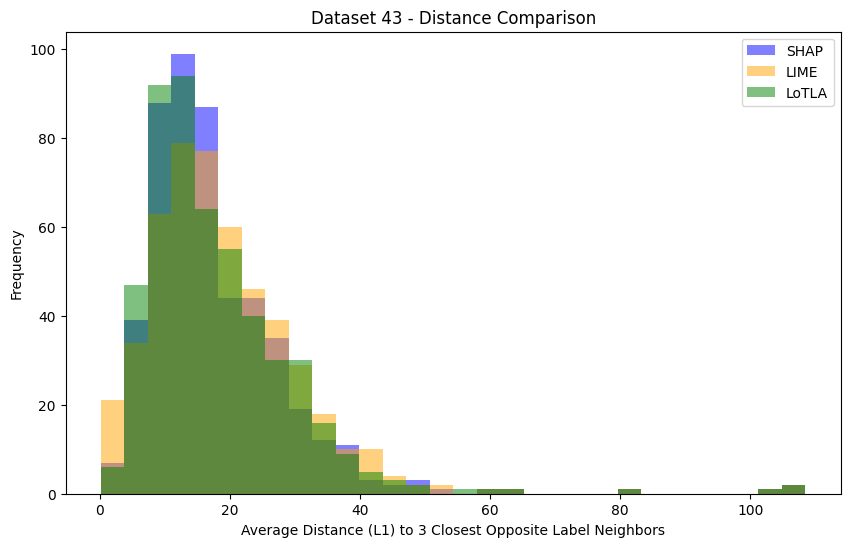

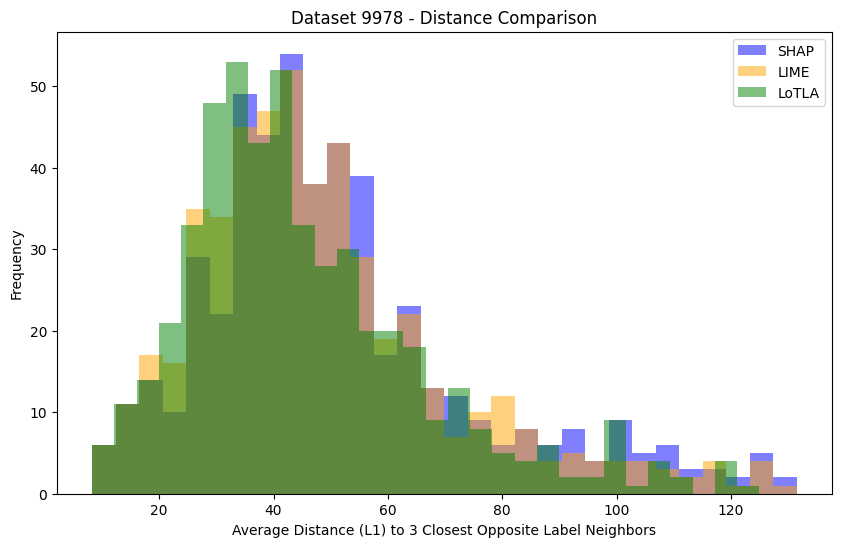

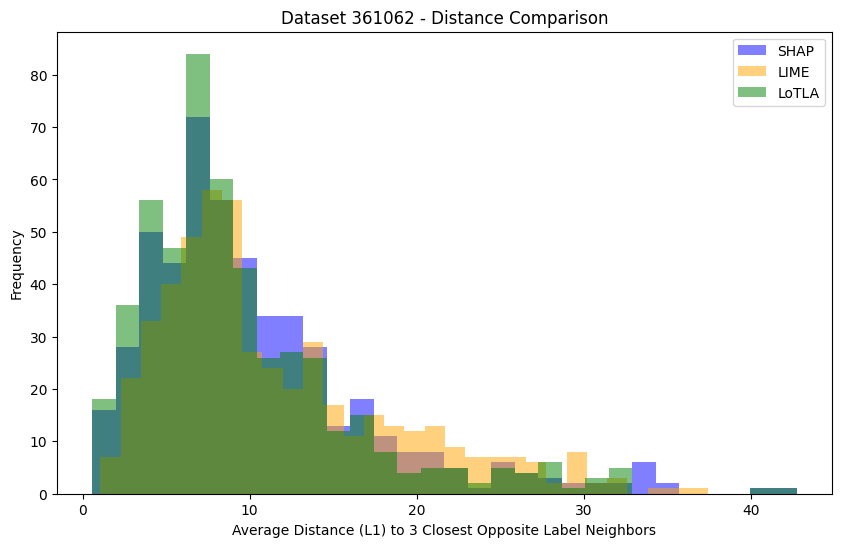

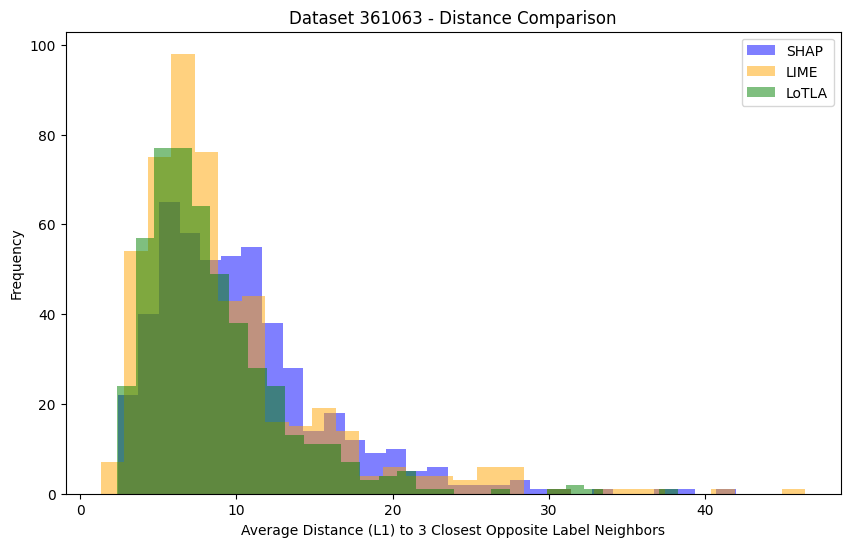

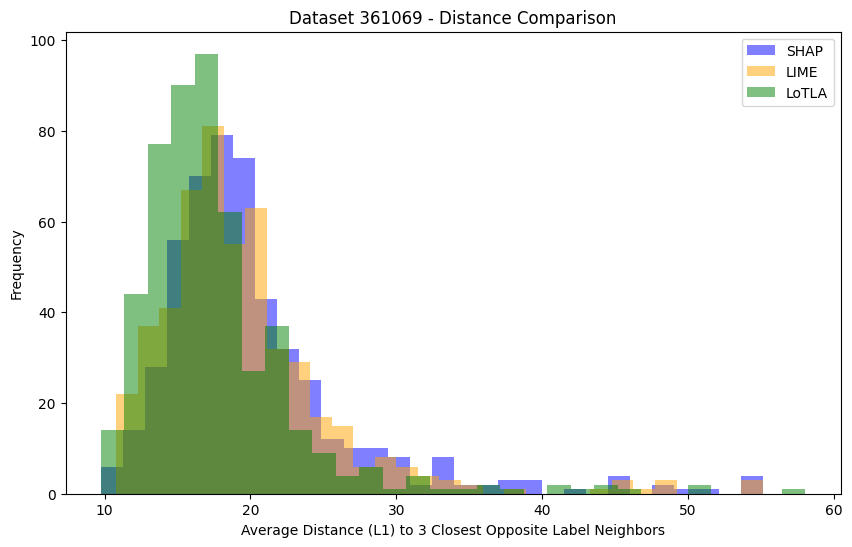

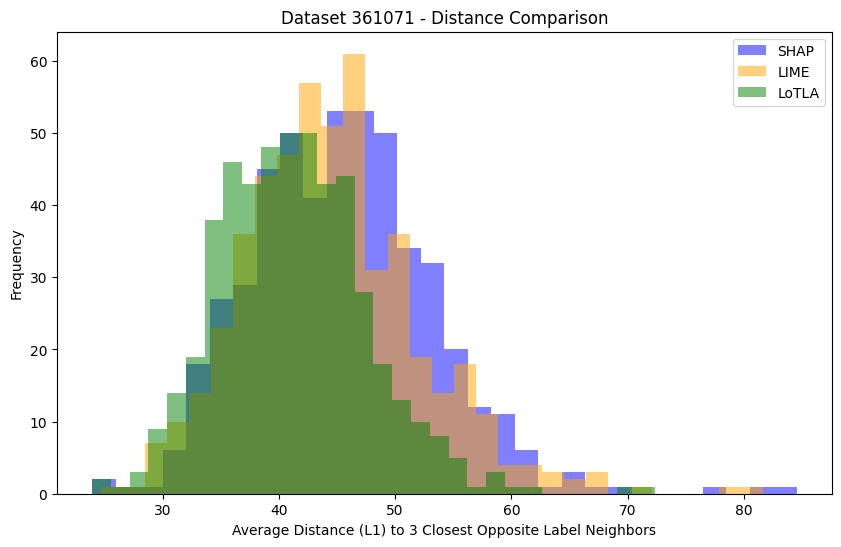

In [4]:
# data_id = 9978
k = 1
nbr_dist = "l1"
cfact_dist = "l1"
labels = "preds"

for data_id in [43, 9978, 361062, 361063, 361069, 361071]:

    shap_distances = np.loadtxt(f"results-1000/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lime_distances = np.loadtxt(f"results-1000/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lmdi_distances = np.loadtxt(f"results-1000/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lmdi_noraw_distances = np.loadtxt(f"results-1000/openml_{data_id}/lmdi_noraw/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    raw_distances = np.loadtxt(f"results-1000/openml_{data_id}/raw/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")

    # print means and medians of each:
    # print("SHAP - Mean:", np.mean(shap_distances), "Median:", np.median(shap_distances))
    # print("LIME - Mean:", np.mean(lime_distances), "Median:", np.median(lime_distances))
    # print("LMDI - Mean:", np.mean(lmdi_distances), "Median:", np.median(lmdi_distances))
    # print("LMDI (No Raw Feature) - Mean:", np.mean(lmdi_noraw_distances), "Median:", np.median(lmdi_noraw_distances))
    # print("Raw Data Mean:", np.mean(raw_distances), "Median:", np.median(raw_distances))


    # plot distances
    plt.figure(figsize=(10, 6))
    plt.hist(shap_distances, bins=30, alpha=0.5, label='SHAP', color='blue')
    plt.hist(lime_distances, bins=30, alpha=0.5, label='LIME', color='orange')
    plt.hist(lmdi_distances, bins=30, alpha=0.5, label='LoTLA', color='green')
    # plt.hist(lmdi_noraw_distances, bins=30, alpha=0.5, label='LoTLA (No Raw Feature)', color='red')
    # plt.hist(raw_distances, bins=30, alpha=0.5, label='Raw Data', color='purple')
    plt.xlabel('Average Distance (L1) to 3 Closest Opposite Label Neighbors')
    plt.ylabel('Frequency')
    plt.title(f'Dataset {data_id} - Distance Comparison')
    plt.legend()
    plt.show()

In [5]:
number_mean_wins = 0
number_median_wins = 0
number_tries = 0
over_shap = []
over_lime = []
means_lst = []
medians_lst = []
labels = "oracle"
k = 1
for data_id in [43, 9978, 361062, 361063, 361069, 361071]:
    for k in [1, 3, 5, 7, 9]:
        for nbr_dist in ["l1", "l2"]:
            for cfact_dist in ["l1", "l2"]:
                shap_distances = np.loadtxt(f"results-1000/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
                lime_distances = np.loadtxt(f"results-1000/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
                lmdi_distances = np.loadtxt(f"results-1000/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
                # print means and medians of each:
                means = {
                    "shap": np.mean(shap_distances),
                    "lime": np.mean(lime_distances),
                    "lmdi": np.mean(lmdi_distances)
                }
                medians = {
                    "shap": np.median(shap_distances),
                    "lime": np.median(lime_distances),
                    "lmdi": np.median(lmdi_distances)
                }
                means_lst.append(means)
                medians_lst.append(medians)
                
                over_shap.append(means["shap"]-means["lmdi"])
                over_lime.append(means["lime"]-means["lmdi"])
                
                if means["lmdi"] < means["shap"] and means["lmdi"] < means["lime"]:
                    number_mean_wins += 1
                if medians["lmdi"] < medians["shap"] and medians["lmdi"] < medians["lime"]:
                    number_median_wins += 1
                number_tries += 1

print("Number of Wins for LMDI (Mean):", number_mean_wins)
print("Number of Wins for LMDI (Median):", number_median_wins)
print("Number of Tries:", number_tries)
print("Percentage of Wins for LMDI (Mean):", number_mean_wins / number_tries)
print("Percentage of Wins for LMDI (Median):", number_median_wins / number_tries)            


Number of Wins for LMDI (Mean): 117
Number of Wins for LMDI (Median): 118
Number of Tries: 120
Percentage of Wins for LMDI (Mean): 0.975
Percentage of Wins for LMDI (Median): 0.9833333333333333


In [6]:
over_shap

[0.10518664962565438,
 -0.0662376337449917,
 -0.5474788488713109,
 0.045658236279013664,
 1.1466351935004937,
 0.5950999632707319,
 1.0584038978583798,
 0.5754815829363382,
 1.26519351659352,
 0.6903939788312599,
 1.0996490447962088,
 0.6254716675136871,
 1.4680320277530186,
 0.7775875772600784,
 1.6717201331688045,
 0.9159297721326025,
 1.802940978148822,
 0.9502958085264064,
 1.9246606276964329,
 1.093237954659501,
 5.5805132297994575,
 0.5952519781467815,
 6.943118142827672,
 0.9107515802021302,
 5.454826292316241,
 0.6073353886813413,
 5.897266594399056,
 0.6977693551046897,
 5.6528608201132045,
 0.6577500239477594,
 5.830014468499947,
 0.6990885287962509,
 5.743379454094423,
 0.6461479616691896,
 6.133300454373256,
 0.7077653344029535,
 5.639533908415672,
 0.6188396733723565,
 6.74184322876544,
 0.7726445887096034,
 0.748985336723738,
 0.2299238178729146,
 0.41669995814468663,
 0.12209588508446867,
 0.8231551311081269,
 0.26078397601390524,
 0.6129353368279222,
 0.1949413251373712

In [7]:
over_lime

[1.3062606286066867,
 0.5024990696529752,
 -1.1438466849936546,
 -0.24249292423507374,
 1.938535054028442,
 0.9845560748570001,
 0.2843459489481539,
 0.4922138178467197,
 1.7147183483884696,
 0.9545228506759802,
 0.6122209327759478,
 0.6778726408886699,
 1.759279630498586,
 1.008391980054192,
 1.1497923936003858,
 0.8779051490208873,
 1.68676557229508,
 0.977945127067799,
 1.3388206234428957,
 0.979983158099027,
 2.937882309218473,
 0.4003146410551084,
 3.8435329102038054,
 0.5693954517047937,
 3.598324354804589,
 0.4656667226492699,
 4.756972629875577,
 0.6384549076346531,
 3.3373036052995246,
 0.40112372242868055,
 3.853952117525708,
 0.4741644123681521,
 2.7983833404278045,
 0.33076391144351547,
 3.0303143776001704,
 0.3638137609313805,
 2.6830524281214636,
 0.31117449211194526,
 3.1510861820621514,
 0.3618246880638445,
 1.9723550941981376,
 1.1505296103681255,
 1.2579474750282245,
 0.9070181825306625,
 1.720680078828087,
 1.0643351710987545,
 1.349524858925804,
 0.9919477338948983,

In [8]:
number_mean_wins = 0
number_median_wins = 0
number_tries = 0
over_shap = []
over_lime = []
means_lst = []
medians_lst = []
labels = "preds"
k = 1
nbr_dist = "l1"
cfact_dist = "l1"
for data_id in [43, 9978, 361062, 361063, 361069, 361071]:
    shap_distances = np.loadtxt(f"results-1000/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lime_distances = np.loadtxt(f"results-1000/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lmdi_distances = np.loadtxt(f"results-1000/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    # print means and medians of each:
    means = {
        "shap": np.mean(shap_distances),
        "lime": np.mean(lime_distances),
        "lmdi": np.mean(lmdi_distances)
    }
    medians = {
        "shap": np.median(shap_distances),
        "lime": np.median(lime_distances),
        "lmdi": np.median(lmdi_distances)
    }
    
    means_lst.append(means)
    medians_lst.append(medians)
    
    over_shap.append(means["shap"]-means["lmdi"])
    over_lime.append(means["lime"]-means["lmdi"])
    
    if means["lmdi"] < means["shap"] and means["lmdi"] < means["lime"]:
        print(f"Data ID: {data_id}")
        number_mean_wins += 1
    if medians["lmdi"] < medians["shap"] and medians["lmdi"] < medians["lime"]:
        print(f"Data ID: {data_id}")
        number_median_wins += 1
    number_tries += 1

print("Number of Wins for LMDI (Mean):", number_mean_wins)
print("Number of Wins for LMDI (Median):", number_median_wins)
print("Number of Tries:", number_tries)
print("Percentage of Wins for LMDI (Mean):", number_mean_wins / number_tries)
print("Percentage of Wins for LMDI (Median):", number_median_wins / number_tries)

Data ID: 9978
Data ID: 9978
Data ID: 361062
Data ID: 361062
Data ID: 361063
Data ID: 361063
Data ID: 361069
Data ID: 361069
Data ID: 361071
Data ID: 361071
Number of Wins for LMDI (Mean): 5
Number of Wins for LMDI (Median): 5
Number of Tries: 6
Percentage of Wins for LMDI (Mean): 0.8333333333333334
Percentage of Wins for LMDI (Median): 0.8333333333333334


In [13]:
number_mean_wins = 0
number_median_wins = 0
number_tries = 0
over_shap = []
over_lime = []
means_lst = []
medians_lst = []
labels = "preds"
k = 1
nbr_dist = "l1"
cfact_dist = "l1"
for data_id in [43, 9978, 361062, 361063, 361069, 361071]:
    shap_distances = np.loadtxt(f"results/openml_{data_id}/shap/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lime_distances = np.loadtxt(f"results/openml_{data_id}/lime/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    lmdi_distances = np.loadtxt(f"results/openml_{data_id}/lmdi/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    blotla_distances = np.loadtxt(f"results/openml_{data_id}/lmdi_noraw/{labels}/k{k}/nbr-dist-{nbr_dist}_cfact-dist-{cfact_dist}.csv", delimiter=",")
    # print means and medians of each:
    means = {
        "shap": np.mean(shap_distances),
        "lime": np.mean(lime_distances),
        "lmdi": np.mean(lmdi_distances),
        "blotla": np.mean(blotla_distances)
    }
    medians = {
        "shap": np.median(shap_distances),
        "lime": np.median(lime_distances),
        "lmdi": np.median(lmdi_distances),
        "blotla": np.median(blotla_distances)
    }
    
    means_lst.append(means)
    medians_lst.append(medians)
    
    over_shap.append(means["shap"]-means["lmdi"])
    over_lime.append(means["lime"]-means["lmdi"])
    
    if means["lmdi"] < means["shap"] and means["lmdi"] < means["lime"]:
        print(f"Data ID: {data_id}")
        number_mean_wins += 1
    if medians["lmdi"] < medians["shap"] and medians["lmdi"] < medians["lime"]:
        print(f"Data ID: {data_id}")
        number_median_wins += 1
    number_tries += 1

print("Number of Wins for LMDI (Mean):", number_mean_wins)
print("Number of Wins for LMDI (Median):", number_median_wins)
print("Number of Tries:", number_tries)
print("Percentage of Wins for LMDI (Mean):", number_mean_wins / number_tries)
print("Percentage of Wins for LMDI (Median):", number_median_wins / number_tries)

Data ID: 43
Data ID: 43
Data ID: 9978
Data ID: 9978
Data ID: 361062
Data ID: 361062
Data ID: 361063
Data ID: 361063
Data ID: 361069
Data ID: 361069
Data ID: 361071
Data ID: 361071
Number of Wins for LMDI (Mean): 6
Number of Wins for LMDI (Median): 6
Number of Tries: 6
Percentage of Wins for LMDI (Mean): 1.0
Percentage of Wins for LMDI (Median): 1.0


In [14]:
medians_lst

[{'shap': 14.095641520689242,
  'lime': 18.93522367812693,
  'lmdi': 12.903445068746805,
  'blotla': 16.17865463963244},
 {'shap': 50.49136851324596,
  'lime': 46.55548244041392,
  'lmdi': 42.206347850664855,
  'blotla': 48.27922646877438},
 {'shap': 8.824478497263044,
  'lime': 9.363537311553955,
  'lmdi': 7.796628339681774,
  'blotla': 8.43773639947176},
 {'shap': 8.844985862262547,
  'lime': 8.017016543075442,
  'lmdi': 6.556180695770308,
  'blotla': 8.826509679667652},
 {'shap': 19.297919404809363,
  'lime': 18.740224375389516,
  'lmdi': 17.57850780058652,
  'blotla': 19.14587843324989},
 {'shap': 44.39347366214497,
  'lime': 44.46839039865881,
  'lmdi': 40.47846425639,
  'blotla': 43.84705500549171}]

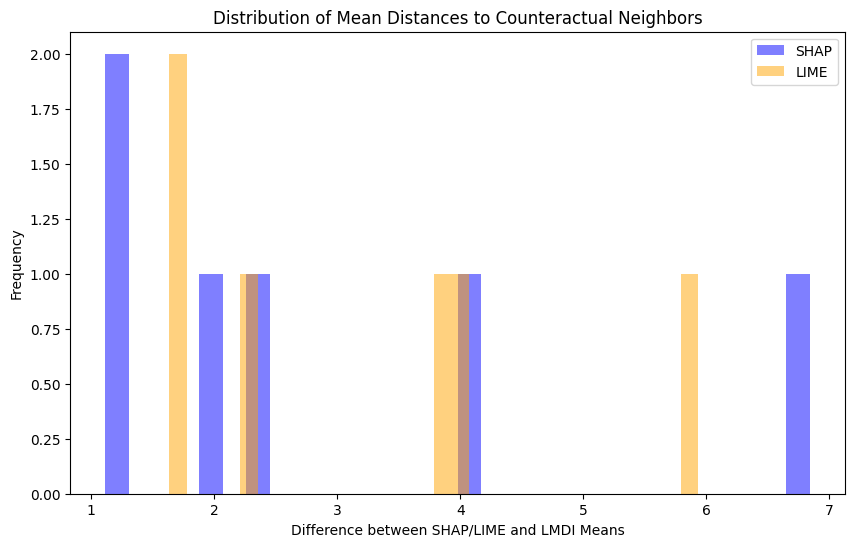

In [11]:
# plot distribution of over_shap and over_lime
plt.figure(figsize=(10, 6))
plt.hist(over_shap, bins=30, alpha=0.5, label='SHAP', color='blue')
plt.hist(over_lime, bins=30, alpha=0.5, label='LIME', color='orange')
plt.xlabel('Difference between SHAP/LIME and LMDI Means')
plt.ylabel('Frequency')
plt.title('Distribution of Mean Distances to Counteractual Neighbors')
plt.legend()
plt.show()